# Aplicar Prophet sobre los datos limpios.

**Autor:** Jean Pool Marín Betancur  
**Fecha:** 2025-06-05
**Versión:** 1.0  

---
# 1. Configuración del Entorno e Importaciones:
---

In [428]:
# Se importan las librebrias necesarias
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib


# Se importan las librerias personalizadas.
sys.path.append(os.path.abspath('..'))
import src.train_prophet_models as tpm

In [429]:
# Configuración de Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_rows', 50)

# Configuración de Matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (30, 20)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Configuación de NumPy
np.set_printoptions(precision=2, suppress=True)

In [430]:
# Se define la ruta y se cargan los datos limpios.
data_path = os.path.join('..','..', '01_data_preparation', 'data', 'processed', 'US_Renewable_Energy_Consumption_Imputed.csv')
df_processed = pd.read_csv(data_path , index_col='Datetime', parse_dates=True)
# Se definen las columnas de interés.
comsumption_columns = [
    'Hydroelectric Power', 'Geothermal Energy', 'Solar Energy',
    'Wind Energy', 'Wood Energy', 'Waste Energy',
    'Fuel Ethanol, Excluding Denaturant','Biomass Losses and Co-products',
    'Biomass Energy','Renewable Diesel Fuel','Total Renewable Energy',
    'Other Biofuels','Conventional Hydroelectric Power', 'Biodiesel'
]
#  Se agrupan los sectores de consumo de energía renovable.
df_processed = df_processed.groupby(['Datetime'])
df_processed = df_processed[comsumption_columns].sum()
df_processed 

,Hydroelectric Power,Geothermal Energy,Solar Energy,Wind Energy,Wood Energy,Waste Energy,"Fuel Ethanol, Excluding Denaturant",Biomass Losses and Co-products,Biomass Energy,Renewable Diesel Fuel,Total Renewable Energy,Other Biofuels,Conventional Hydroelectric Power,Biodiesel
Datetime,,,,,,,,,,,,,,
1973-01-01,3.07,1.91,0.00,0.00,144.93,0.61,0.00,0.00,199.16,0.00,691.84,0.00,342.16,0.00
1973-02-01,4.92,2.27,0.00,0.00,131.06,0.76,0.00,0.00,180.10,0.00,724.38,0.00,405.26,0.00
1973-03-01,5.23,2.41,0.00,0.00,145.08,0.87,0.00,0.00,199.35,0.00,781.21,0.00,428.27,0.00
1973-04-01,5.13,2.65,0.00,0.00,140.30,0.91,0.00,0.00,192.84,0.00,756.48,0.00,414.65,0.00
1973-05-01,5.21,2.62,0.00,0.00,144.94,1.00,0.00,0.00,199.25,0.00,771.23,0.00,418.22,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,1.25,12.46,108.46,97.45,185.60,50.66,158.63,343.87,565.75,169.77,"2,153.36",13.12,339.75,106.58
2023-09-01,1.16,12.29,94.78,96.38,174.87,49.30,143.97,337.83,535.64,176.77,"2,041.20",16.29,289.30,112.62
2023-10-01,1.06,12.71,86.24,124.56,176.67,52.65,157.14,349.48,552.91,165.63,"2,115.98",18.47,305.87,112.59


## 2. Preparación de Datos para Prophet

In [431]:
# Selecciona la Serie Temporal a Pronosticar 
target_prophet = 'Biomass Energy'

# Crear el DataFrame en el formato de Prophet ('ds', 'y'), la columna de fecha se llamara 'ds' y la de valor 'y'
df_prophet_ready = df_processed.reset_index() # Pone el índice 'datetime' como una columna
df_prophet_ready = df_prophet_ready[['Datetime', target_prophet]].copy()
df_prophet_ready.rename(columns={'Datetime': 'ds', target_prophet: 'y'}, inplace=True)


## 3. División de Datos (Cronológica)


In [432]:
# Definir un punto de corte para la división. Por ejemplo, usar los últimos 12 o 24 meses para prueba.
num_test_periods = 24 # Meses
train_prophet = df_prophet_ready.iloc[:-num_test_periods]
test_prophet_actuals = df_prophet_ready.iloc[-num_test_periods:]

print(f"Datos de entrenamiento: {len(train_prophet)} periodos, desde {train_prophet['ds'].min()} hasta {train_prophet['ds'].max()}")
print(f"Datos de prueba: {len(test_prophet_actuals)} periodos, desde {test_prophet_actuals['ds'].min()} hasta {test_prophet_actuals['ds'].max()}")

Datos de entrenamiento: 588 periodos, desde 1973-01-01 00:00:00 hasta 2021-12-01 00:00:00
Datos de prueba: 24 periodos, desde 2022-01-01 00:00:00 hasta 2023-12-01 00:00:00


## 4. Instanciación y Entrenamiento del Modelo Prophet

In [433]:
# Instanciar Prophet
model_prophet = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative', # Probar 'additive' (defecto) o 'multiplicative' si la estacionalidad crece con la tendencia
    changepoint_prior_scale= 0.75, # Parámetro para ajustar la flexibilidad de la tendencia
    seasonality_prior_scale= 10 # Parámetro para ajustar la fuerza de la estacionalidad
)

# Ajustar el modelo a los datos de entrenamiento
model_prophet.fit(train_prophet)
print("Modelo Prophet entrenado exitosamente.")

19:33:37 - cmdstanpy - INFO - Chain [1] start processing
19:33:37 - cmdstanpy - INFO - Chain [1] done processing


Modelo Prophet entrenado exitosamente.


## 5. Generación de Fechas Futuras para Pronóstico

In [434]:
# Número de periodos a pronosticar.
periods_to_forecast = len(test_prophet_actuals)

# creacon de un DataFrame de fechas futuras
future_dates = model_prophet.make_future_dataframe(periods= 48, freq='MS')

print("\nÚltimas fechas del historial y primeras fechas futuras generadas:")
print(train_prophet['ds'].tail(3))
print(future_dates.tail(periods_to_forecast + 3)) # Muestra un poco de contexto


Últimas fechas del historial y primeras fechas futuras generadas:
585   2021-10-01
586   2021-11-01
587   2021-12-01
Name: ds, dtype: datetime64[ns]
            ds
609 2023-10-01
610 2023-11-01
611 2023-12-01
612 2024-01-01
613 2024-02-01
614 2024-03-01
615 2024-04-01
616 2024-05-01
617 2024-06-01
618 2024-07-01
619 2024-08-01
620 2024-09-01
621 2024-10-01
622 2024-11-01
623 2024-12-01
624 2025-01-01
625 2025-02-01
626 2025-03-01
627 2025-04-01
628 2025-05-01
629 2025-06-01
630 2025-07-01
631 2025-08-01
632 2025-09-01
633 2025-10-01
634 2025-11-01
635 2025-12-01


## 6. Realización de Predicciones

In [435]:
# Se realizan predicciones en el conjunto de prueba.
forecast = model_prophet.predict(future_dates)

## 7. Visualización del Pronóstico

C:\Users\acer\AppData\Local\Temp\ipykernel_6828\3323740916.py:7: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



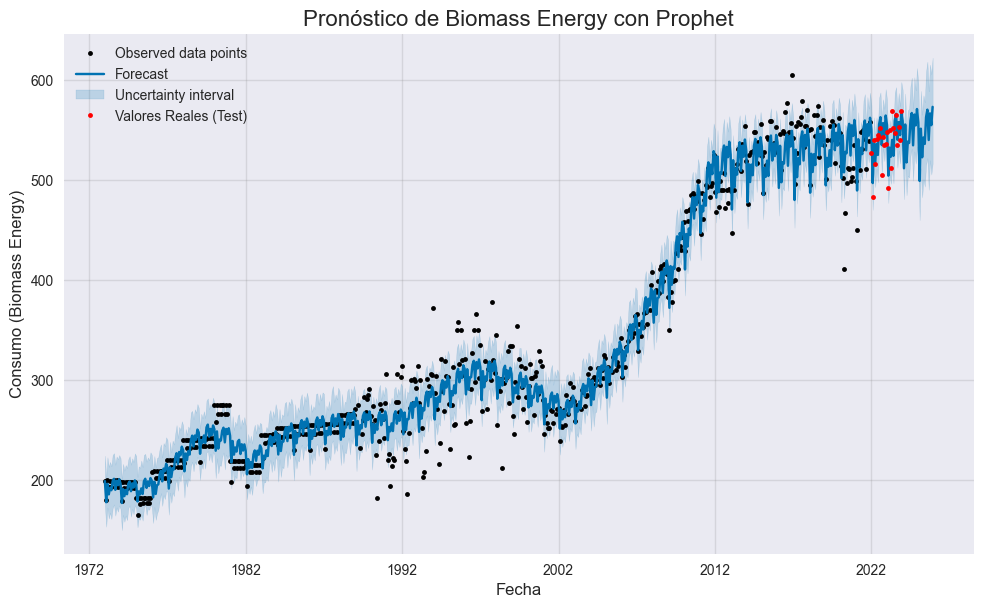

In [436]:
# Gráfico 1: Pronóstico principal 
fig1 = model_prophet.plot(forecast, include_legend=True)
plt.title(f'Pronóstico de {target_prophet} con Prophet', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel(f'Consumo ({target_prophet})', fontsize=12)
plt.plot(
    test_prophet_actuals['ds'].dt.to_pydatetime(), # Convertir a datetime de python para mejor compatibilidad con matplotlib
    test_prophet_actuals['y'],
    color='red', linestyle='none', label='Valores Reales (Test)' ,marker='.'
)
plt.legend()
plt.show()

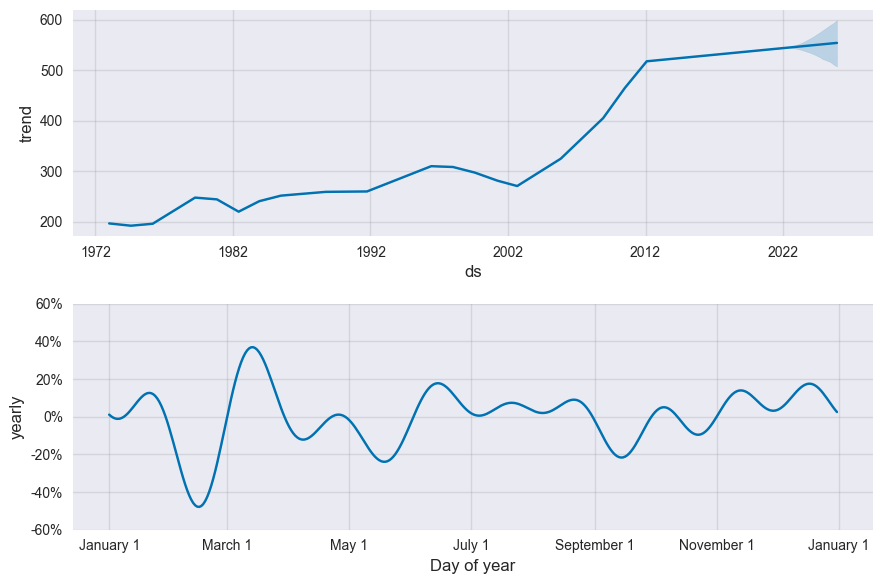

In [437]:
# Gráfico 2: Componentes del modelo 
# Muestra la tendencia, estacionalidad anual, y cualquier otra estacionalidad/regresor añadido.
fig2 = model_prophet.plot_components(forecast)
plt.show()

In [438]:
fig_plotly1 = plot_plotly(model_prophet, forecast)
fig_plotly1.show()
fig_plotly2 = plot_components_plotly(model_prophet, forecast)
fig_plotly2.show()

## 8. Evaluación del Pronóstico

In [439]:
# Unir los valores reales de prueba con las predicciones yhat
# Nos interesa yhat solo para el período de prueba
forecast_on_test_period = forecast[forecast['ds'].isin(test_prophet_actuals['ds'])]
eval_df = pd.merge(test_prophet_actuals, forecast_on_test_period[['ds', 'yhat']], on='ds', how='inner')

rmse_prophet = np.sqrt(mean_squared_error(eval_df['y'], eval_df['yhat']))
mae_prophet = mean_absolute_error(eval_df['y'], eval_df['yhat'])

# Calcular MAPE (Mean Absolute Percentage Error)
# Evitar división por cero si y_true es 0
mape_prophet = np.mean(np.abs((eval_df['y'] - eval_df['yhat']) / np.where(eval_df['y'] == 0, 1e-6, eval_df['y']))) * 100


print(f"\n--- Métricas de Evaluación para Prophet ({target_prophet}) en el Conjunto de Prueba ---")
print(f"RMSE: {rmse_prophet:.4f}")
print(f"MAE: {mae_prophet:.4f}")
print(f"MAPE: {mape_prophet:.2f}%")

print("\nComparativa de valores reales vs. predichos en prueba:")
print(eval_df[['ds', 'y', 'yhat']].tail())


--- Métricas de Evaluación para Prophet (Biomass Energy) en el Conjunto de Prueba ---
RMSE: 15.7688
MAE: 12.9178
MAPE: 2.42%

Comparativa de valores reales vs. predichos en prueba:
           ds      y   yhat
19 2023-08-01 565.75 566.48
20 2023-09-01 535.64 540.45
21 2023-10-01 552.91 558.17
22 2023-11-01 539.76 545.10
23 2023-12-01 569.49 567.08
